In [2]:
# Cell 1: Import required libraries
import splitfolders
import tensorflow as tf
import os
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [1]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Cell 2: Split existing dataset structure
input_dir = "/kaggle/input/neural-network-stylegan-real-fake-dataset/output"

splitfolders.ratio(
    input_dir,  # Use the existing parent directory
    output="/kaggle/working/dataset_split",
    seed=42,
    ratio=(0.8, 0.1, 0.1),  # train, val, test
    group_prefix=None,
    move=False  # Keep original files intact
)

Copying files: 17763 files [06:50, 43.24 files/s]


In [4]:
# Cell 3: Create data generators
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/dataset_split/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    '/kaggle/working/dataset_split/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    '/kaggle/working/dataset_split/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Verify class indices
print("Class mappings:", train_generator.class_indices)

Found 14210 images belonging to 2 classes.
Found 1776 images belonging to 2 classes.
Found 1777 images belonging to 2 classes.
Class mappings: {'augmented': 0, 'original': 1}


In [5]:
# Cell 4: Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,263,809 (73.49 MB)

 Trainable params: 19,263,809 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Cell 6: Training configuration
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [7]:
# Cell 7: Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


444/445 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5456 - loss: 0.6930
Epoch 1: val_accuracy improved from -inf to 0.56306, saving model to best_model.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 608s 1s/step - accuracy: 0.5456 - loss: 0.6930 - val_accuracy: 0.5631 - val_loss: 0.6862
Epoch 2/20
444/445 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5660 - loss: 0.6859
Epoch 2: val_accuracy did not improve from 0.56306
445/445 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/step - accuracy: 0.5660 - loss: 0.6859 - val_accuracy: 0.5631 - val_loss: 0.6856
Epoch 3/20
444/445 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5650 - loss: 0.6865
Epoch 3: val_accuracy did not improve from 0.56306
445/445 ━━━━━━━━━━━━━━━━━━━━ 531s 1s/step - accuracy: 0.5650 - loss: 0.6865 - val_accuracy: 0.5631 - val_loss: 0.6848
Epoch 4/20
444/445 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5639 - loss: 0.6849
Epoch 4: val_accuracy did not improve from 0.56306
445/445 ━━━━━━━━━━━━━━━━━━━━ 531s 1s/step - accuracy: 0.5639 - loss: 0.6849 - 

In [8]:
# Cell 8: Evaluate on test set
print("\nEvaluating on test set:")
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.2%}')
print(f'Test loss: {test_loss:.4f}')


Evaluating on test set:
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5893 - loss: 0.6670
Test accuracy: 59.93%
Test loss: 0.6632


In [9]:
# Cell 8: Evaluate on test set and generate ROC curve
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
# Load best model
best_model = tf.keras.models.load_model('best_model.keras')

# Prepare test generator with shuffle=False for consistent ordering
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/dataset_split/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 1777 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 802ms/step


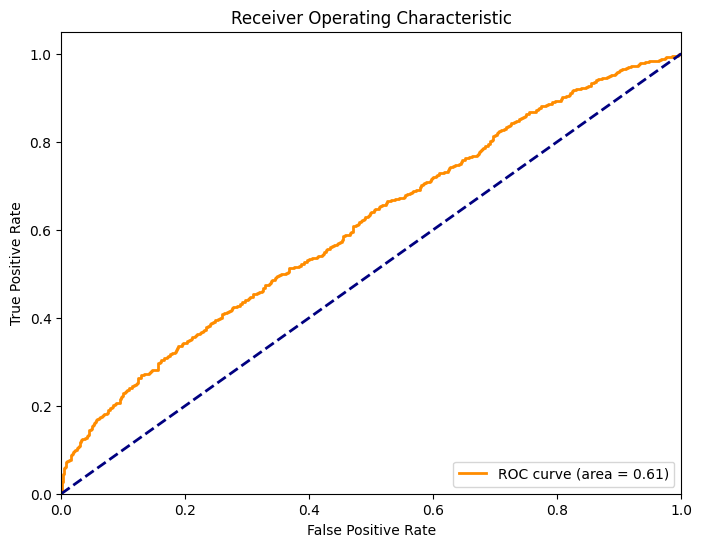

In [11]:
# Get predictions and true labels
y_pred_probs = best_model.predict(test_generator).flatten()
y_true = test_generator.classes

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Classification Report:
              precision    recall  f1-score   support

   augmented       0.60      0.90      0.72      1000
    original       0.63      0.23      0.34       777

    accuracy                           0.60      1777
   macro avg       0.62      0.56      0.53      1777
weighted avg       0.61      0.60      0.55      1777



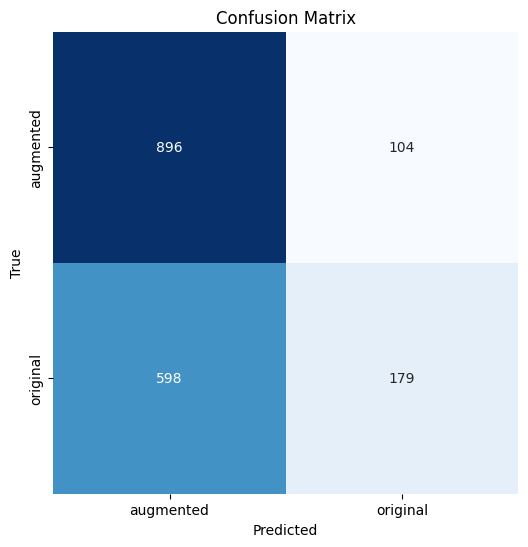

In [12]:
# Cell 9: Generate classification report and confusion matrix
y_pred = (y_pred_probs >= 0.5).astype(int)
class_names = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


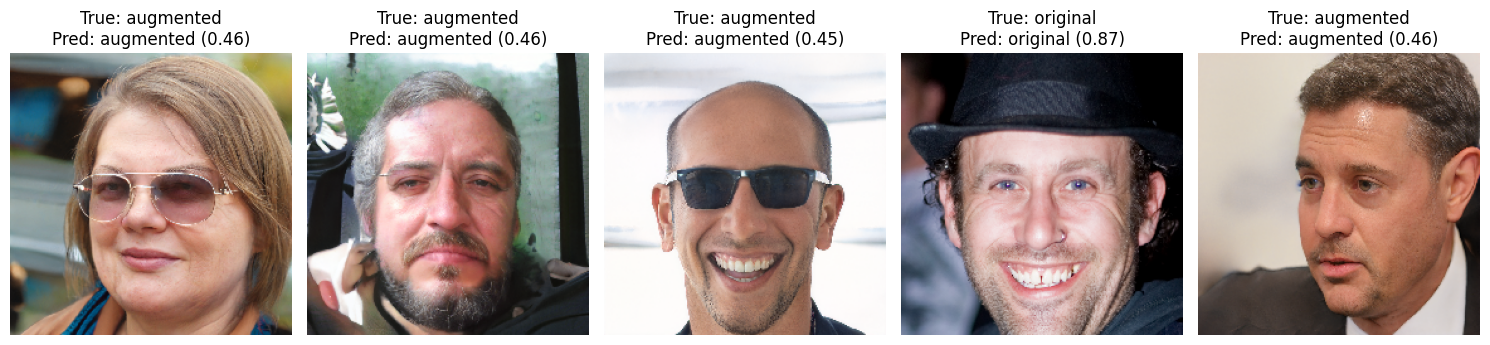

In [13]:
# Cell 10: Test 5 random images
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Get file paths and labels
file_paths = [os.path.join('/kaggle/working/dataset_split/test', f) for f in test_generator.filenames]

# Randomly select 5 images
np.random.seed(42)
random_indices = np.random.choice(len(file_paths), 5, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    # Load and preprocess image
    img = load_img(file_paths[idx], target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    pred_prob = best_model.predict(img_array)[0][0]
    pred_class = class_names[int(pred_prob >= 0.5)]
    true_class = class_names[y_true[idx]]
    
    # Plot results
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPred: {pred_class} ({pred_prob:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Cell 11 (Revised): Save and verify model
import os

# Save in Keras format
keras_path = 'final_base_model.keras'
best_model.save(keras_path)

# Verify files exist
print("\nSaved files verification:")
print(f"Keras model exists: {os.path.exists(keras_path)}")
print(f"SavedModel exists: {os.path.exists(tf_path)}")

# For Kaggle users - list working directory contents
print("\nWorking directory contents:")
!ls -lh


Saved files verification:
Keras model exists: True
SavedModel exists: False

Working directory contents:
total 442M
-rw-r--r-- 1 root root 221M Mar 29 00:44 best_model.keras
drwxr-xr-x 5 root root 4.0K Mar 28 21:52 dataset_split
-rw-r--r-- 1 root root 221M Mar 29 00:59 final_base_model.keras
